In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum,count,avg,col,expr,round,date_format,collect_list,size
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
spark=SparkSession.builder.appName("practiceanalytics").getOrCreate()

24/03/18 05:30:37 WARN Utils: Your hostname, Manishas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.1.10.215 instead (on interface en0)
24/03/18 05:30:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/18 05:30:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Read 2019 data from json files directory

In [3]:
inputpath= './data/output1/sales/'
partition='year=2019'
fullpath=f"{inputpath}{partition}"
spark_df=spark.read.format("json").option("inferschema",True).load(fullpath)
spark_df.show(truncate=False)

+--------------+-----------------------------+-------+------+--------------------------+--------+-----+----------------------------------------+-----+
|city          |orderdate                    |orderid|price |product                   |quantity|state|storeaddress                            |month|
+--------------+-----------------------------+-------+------+--------------------------+--------+-----+----------------------------------------+-----+
| San Francisco|2019-12-08T21:09:00.000-06:00|295778 |3.84  |AA Batteries (4-pack)     |1       |CA   |820 Adams St, San Francisco, CA 94016   |12   |
| Los Angeles  |2019-12-02T18:09:00.000-06:00|296047 |2.99  |AAA Batteries (4-pack)    |2       |CA   |433 4th St, Los Angeles, CA 90001       |12   |
| Los Angeles  |2019-12-05T15:49:00.000-06:00|296233 |3.84  |AA Batteries (4-pack)     |1       |CA   |444 8th St, Los Angeles, CA 90001       |12   |
| San Francisco|2019-12-02T20:21:00.000-06:00|296603 |2.99  |AAA Batteries (4-pack)    |1     

### 1.Get the best sales month

In [4]:
spark_df1=spark_df.select(col("month"),col("quantity"),col("price"),expr("price * quantity").alias("sales"))
spark_df1.show()

+-----+--------+------+------+
|month|quantity| price| sales|
+-----+--------+------+------+
|   12|       1|  3.84|  3.84|
|   12|       2|  2.99|  5.98|
|   12|       1|  3.84|  3.84|
|   12|       1|  2.99|  2.99|
|   12|       1|149.99|149.99|
|   12|       1|379.99|379.99|
|   12|       1| 11.99| 11.99|
|   12|       1| 150.0| 150.0|
|   12|       2|  3.84|  7.68|
|   12|       1| 99.99| 99.99|
|   12|       1| 700.0| 700.0|
|   12|       1| 150.0| 150.0|
|   12|       1| 11.95| 11.95|
|   12|       1| 11.95| 11.95|
|   12|       2|  3.84|  7.68|
|   12|       1|  2.99|  2.99|
|   12|       1| 300.0| 300.0|
|   12|       1| 11.95| 11.95|
|   12|       1| 300.0| 300.0|
|   12|       1|1700.0|1700.0|
+-----+--------+------+------+
only showing top 20 rows



In [5]:
spark_df2=(spark_df1.groupBy("month")
          .agg(round(sum("sales"),2).alias("totalsales"))
          .orderBy("totalsales"))
spark_df2.show()         

+-----+----------+
|month|totalsales|
+-----+----------+
|    1|1812742.87|
|    9|2094465.69|
|    2|2200078.08|
|    8|2241083.37|
|    6|2576280.15|
|    7|2646461.32|
|    3|2804973.35|
|    5|3150616.23|
|   11|3197875.05|
|    4|3389217.98|
|   10|3734777.86|
|   12| 4608295.7|
+-----+----------+



In [6]:
pd_df=(spark_df2.orderBy("month")).toPandas()
pd_df

,month,totalsales
0,1,1812742.87
1,2,2200078.08
2,3,2804973.35
3,4,3389217.98
4,5,3150616.23
5,6,2576280.15
6,7,2646461.32
7,8,2241083.37
8,9,2094465.69
9,10,3734777.86


Text(0, 0.5, 'Total Sales')

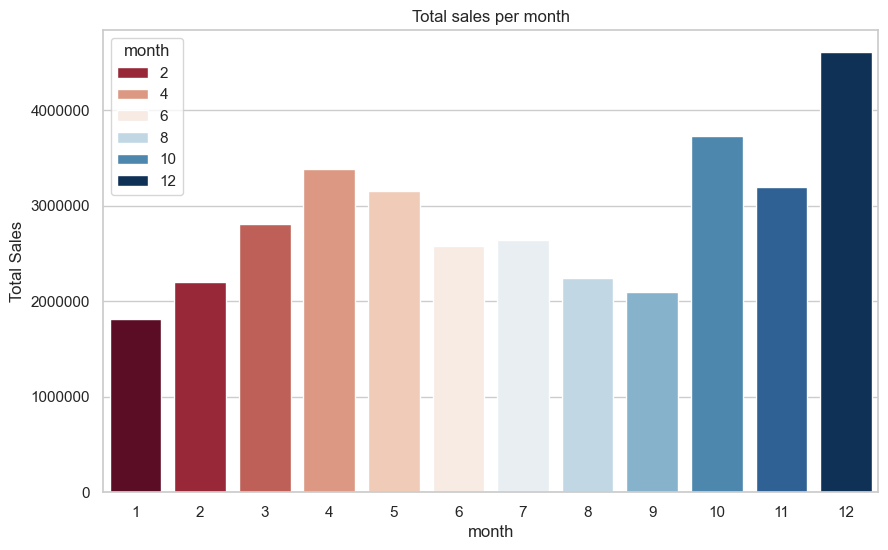

In [7]:
sbn.set_theme(style='whitegrid')
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sbn.barplot(x="month" , y="totalsales",data=pd_df,hue="month",palette="RdBu").set_title("Total sales per month")
plt.ylabel("Total Sales")
           

In [8]:
#print("Seaborn version : {0}".format(sbn.__version__))

### 2.Get the city that sold the most products

In [9]:
city_df=spark_df.groupby("city").agg(sum("quantity").alias("totalproducts")).orderBy("totalproducts",ascending=False)
city_df.show()

+--------------+-------------+
|          city|totalproducts|
+--------------+-------------+
| San Francisco|        50156|
|   Los Angeles|        33246|
| New York City|        27887|
|        Boston|        22490|
|        Dallas|        16705|
|       Atlanta|        16584|
|       Seattle|        16533|
|      Portland|        14035|
|        Austin|        11135|
+--------------+-------------+



In [10]:
city_pd=city_df.toPandas()
city_pd

,city,totalproducts
0,San Francisco,50156
1,Los Angeles,33246
2,New York City,27887
3,Boston,22490
4,Dallas,16705
5,Atlanta,16584
6,Seattle,16533
7,Portland,14035
8,Austin,11135


Text(0, 0.5, 'Total products')

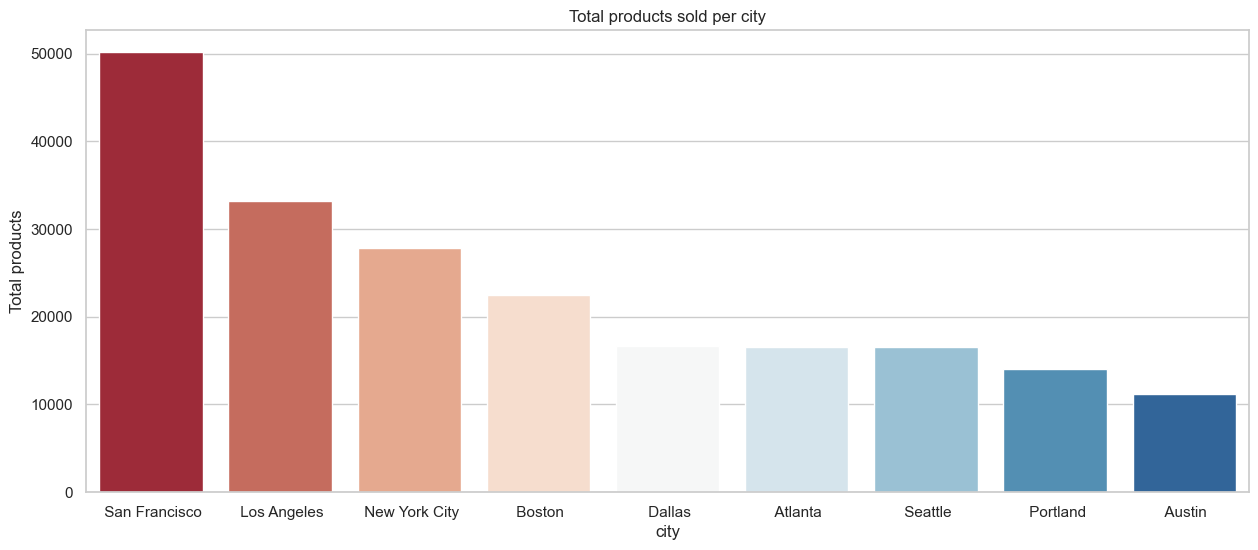

In [11]:
sbn.set_theme(style='whitegrid')
plt.figure(figsize=(15,6))
plt.ticklabel_format(useOffset=False, style="plain")
sbn.barplot(x="city" , y="totalproducts",data=city_pd,hue="city",palette="RdBu").set_title("Total products sold per city")
plt.ylabel("Total products")

### 3.At what time should we display the advertisements to maximize the likelihood of the the customers buying products

In [12]:
adv_df=spark_df.groupby("orderid").agg(count("orderid").alias("count")).where(col("count")>1)
adv_df.show()

+-------+-----+
|orderid|count|
+-------+-----+
| 302708|    2|
| 301127|    2|
| 317757|    2|
| 299953|    2|
| 302881|    2|
| 303986|    2|
| 307749|    2|
| 312270|    2|
| 269650|    2|
| 177719|    2|
| 277548|    2|
| 268529|    2|
| 192643|    2|
| 234628|    2|
| 290395|    2|
| 267325|    2|
| 293958|    2|
| 160894|    2|
| 225350|    2|
| 172267|    2|
+-------+-----+
only showing top 20 rows



In [13]:
adv_df1=(spark_df.select("orderid",date_format("orderdate","HH").cast("int").alias("hour"))
               .distinct()
               .groupby("hour").agg(count("orderid").alias("totalorders")).orderBy("totalorders",ascending=False))
adv_df1.show()

+----+-----------+
|hour|totalorders|
+----+-----------+
|  19|      12377|
|  12|      12082|
|  11|      11882|
|  20|      11763|
|  18|      11761|
|  13|      11682|
|  14|      10522|
|  21|      10499|
|  10|      10492|
|  17|      10476|
|  16|       9960|
|  15|       9761|
|  22|       8453|
|   9|       8404|
|   8|       6036|
|  23|       5990|
|   7|       3836|
|   0|       3748|
|   6|       2375|
|   1|       2246|
+----+-----------+
only showing top 20 rows



In [14]:
adv_pd=adv_df1.toPandas()

Text(0, 0.5, 'Total Orders')

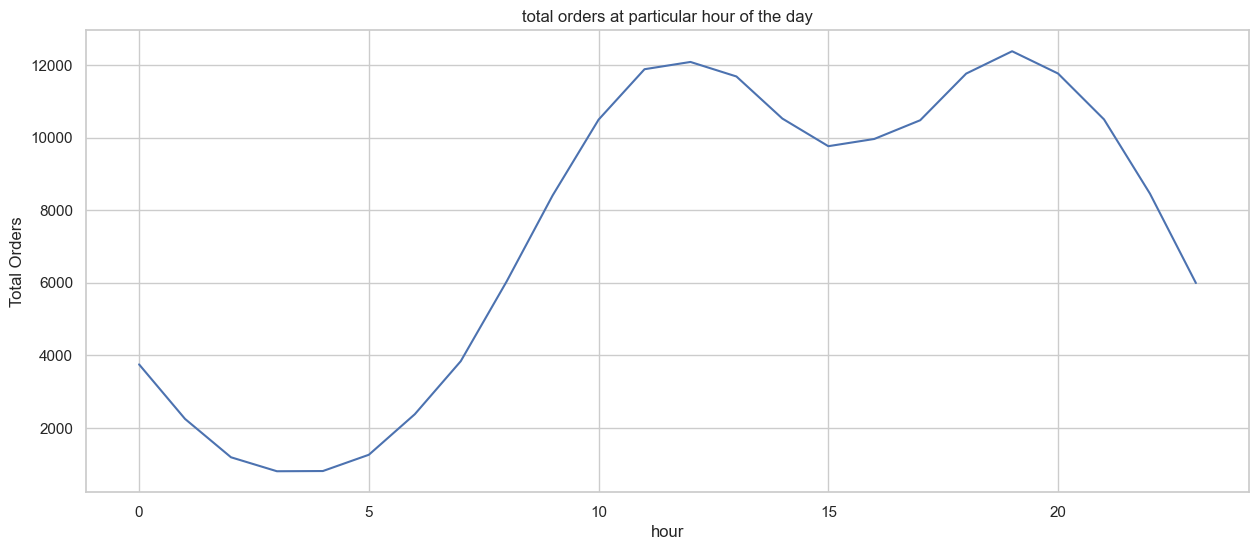

In [15]:
sbn.set_theme(style='whitegrid')
plt.figure(figsize=(15,6))
plt.ticklabel_format(useOffset=False, style="plain")
sbn.lineplot(x="hour" , y="totalorders",data=adv_pd).set_title("total orders at particular hour of the day")
plt.ylabel("Total Orders")

### 4.What products are often sold together in the state of newyork?

In [16]:
spark_df.groupby("orderid").agg(count("state").alias("statecount")).where(col("orderid")>1).show()
spark_df.select("orderid","state").where(col("orderid")=="302708").show()

+-------+----------+
|orderid|statecount|
+-------+----------+
| 308558|         1|
| 310409|         1|
| 302708|         2|
| 308710|         1|
| 318679|         1|
| 307267|         1|
| 303294|         1|
| 311499|         1|
| 299097|         1|
| 310840|         1|
| 310728|         1|
| 319568|         1|
| 297366|         1|
| 312713|         1|
| 314705|         1|
| 299914|         1|
| 303922|         1|
| 298298|         1|
| 298746|         1|
| 305184|         1|
+-------+----------+
only showing top 20 rows

+-------+-----+
|orderid|state|
+-------+-----+
| 302708|   CA|
| 302708|   CA|
+-------+-----+



In [23]:
state_df=(spark_df.filter(col("state")=='NY').groupBy("orderid","state").agg(collect_list("product").alias("productlist"))
             )
state_df=state_df.withColumn("productlistcount",size("productlist"))
state_df.show()
state_df=state_df.filter(col("productlistcount")>1).orderBy("productlistcount",ascending=False)
state_df.show()
state_df=(state_df.groupBy("productlist").agg(count("productlistcount").alias("frequency"))
 .orderBy("frequency",ascending=False)
.where(col("frequency")>1)
)
state_df.show()

+-------+-----+--------------------+----------------+
|orderid|state|         productlist|productlistcount|
+-------+-----+--------------------+----------------+
| 308924|   NY|[iPhone, Wired He...|               2|
| 312563|   NY|[USB-C Charging C...|               1|
| 316630|   NY|[USB-C Charging C...|               1|
| 298165|   NY|  [Wired Headphones]|               1|
| 301034|   NY|[iPhone, Wired He...|               2|
| 305541|   NY|[AA Batteries (4-...|               1|
| 305907|   NY|[AAA Batteries (4...|               1|
| 314919|   NY|[USB-C Charging C...|               1|
| 274947|   NY|[27in 4K Gaming M...|               1|
| 296663|   NY|      [Google Phone]|               1|
| 296939|   NY|[Lightning Chargi...|               1|
| 304687|   NY|  [Wired Headphones]|               1|
| 305406|   NY|[USB-C Charging C...|               1|
| 314696|   NY|  [Wired Headphones]|               1|
| 316514|   NY|[AAA Batteries (4...|               1|
| 319361|   NY|[Apple Airpod

+-------+-----+--------------------+----------------+
|orderid|state|         productlist|productlistcount|
+-------+-----+--------------------+----------------+
| 245008|   NY|[USB-C Charging C...|               3|
| 254703|   NY|[Lightning Chargi...|               3|
| 149936|   NY|[Google Phone, US...|               3|
| 287477|   NY|[Apple Airpods He...|               3|
| 213138|   NY|[USB-C Charging C...|               3|
| 295735|   NY|[Wired Headphones...|               3|
| 292230|   NY|[Google Phone, Bo...|               3|
| 232755|   NY|[Bose SoundSport ...|               3|
| 218995|   NY|[34in Ultrawide M...|               3|
| 155053|   NY|[Wired Headphones...|               3|
| 221229|   NY|[Lightning Chargi...|               3|
| 173066|   NY|[Wired Headphones...|               3|
| 219596|   NY|[Apple Airpods He...|               3|
| 218530|   NY|[Vareebadd Phone,...|               3|
| 194314|   NY|[USB-C Charging C...|               3|
| 159000|   NY|[iPhone, Ligh

+--------------------+---------+
|         productlist|frequency|
+--------------------+---------+
|[iPhone, Lightnin...|       68|
|[Google Phone, US...|       68|
|[USB-C Charging C...|       59|
|[Lightning Chargi...|       58|
|[Google Phone, Wi...|       34|
|[USB-C Charging C...|       30|
|[Apple Airpods He...|       24|
|[iPhone, Wired He...|       24|
|[Wired Headphones...|       22|
|[iPhone, Apple Ai...|       21|
|[Vareebadd Phone,...|       20|
|[Wired Headphones...|       19|
|[Bose SoundSport ...|       13|
|[AAA Batteries (4...|       13|
|[Apple Airpods He...|       12|
|[Google Phone, Bo...|       11|
|[AA Batteries (4-...|       10|
|[Wired Headphones...|       10|
|[AA Batteries (4-...|        9|
|[AA Batteries (4-...|        8|
+--------------------+---------+
only showing top 20 rows

